In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

## Coding RSS Optimiser from Scratch
This code was mainly taken from [this tutorial](https://machinelearningmastery.com/optimize-regression-models/) on optimising the [Residual sum of squares](https://en.wikipedia.org/wiki/Residual_sum_of_squares).

### First prediction on random coefficients

In [2]:
# making up an artifical dataset 

X, y = make_regression(n_samples=1000, n_features=10, n_informative=2, noise=0.2, random_state=2)
print(X.shape, y.shape)

(1000, 10) (1000,)


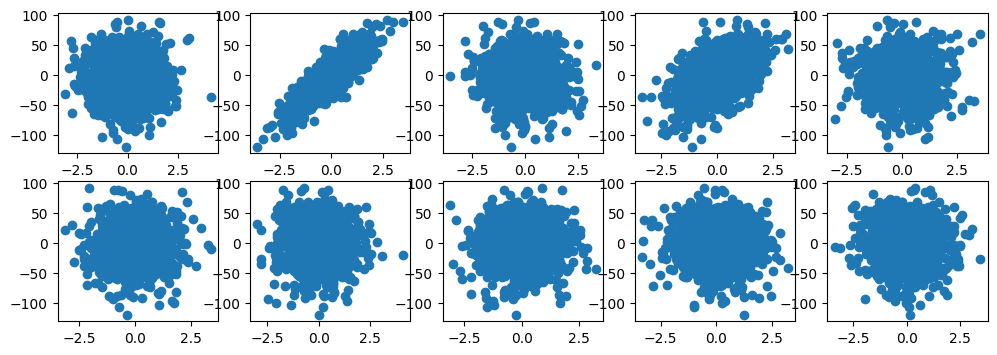

In [20]:
# quick visualisation

fig, axs = plt.subplots(2,5, figsize=(12, 4))
axs[0,0].scatter(X[:,0], y)
axs[0,1].scatter(X[:,1], y)
axs[0,2].scatter(X[:,2], y)
axs[0,3].scatter(X[:,3], y)
axs[0,4].scatter(X[:,4], y)
axs[1,0].scatter(X[:,5], y)
axs[1,1].scatter(X[:,6], y)
axs[1,2].scatter(X[:,7], y)
axs[1,3].scatter(X[:,8], y)
axs[1,4].scatter(X[:,9], y);

This data doesn't look very trustworthy ... 

In [4]:
# function to calculate a prediction for a single row, if coefficients are already given

def predict_row(row, coefficients):
    result = coefficients[-1] # adding the bias (last coefficient, since we will make one more as features we have)
    for i in range(len(row)): # adding the weights
        try:
            result += coefficients[i] * row[i]
        except:               # quick fix, since last feature throws error otherwise
            pass
    return result


In [5]:
# function to generate predictions for a dataset of rows, if coefficients are already given

def predict_dataset(X, coefficients):
    yhats = []
    for row in X:
        yhat = predict_row(row, coefficients)
        yhats.append(yhat)
    return np.array(yhats)

In [6]:
# generating a random set of model coefficients

n_coeff = X.shape[1] + 1
coefficients = np.random.rand(n_coeff)
coefficients

array([0.51982409, 0.87711645, 0.5421075 , 0.76204049, 0.91256378,
       0.7385767 , 0.78269876, 0.77019321, 0.27520862, 0.37123557,
       0.57044658])

In [7]:
# generate predictions for our dataset, using those random coefficients

yhat = predict_dataset(X, coefficients)
yhat[:10] # first 10/1000 yhats

array([ 0.44815178, -3.10823416,  1.58004938, -1.01474614,  0.79221543,
       -0.75773496,  1.08313791,  1.45571606,  2.99018383, -4.42769927])

In [8]:
# evaluating the mean squared error of these predictions

score = mean_squared_error(y, yhat)
print('MSE: %f' % score)

MSE: 1026.554832


In [9]:
# or, more efficiently: function that returns the error of a model

def objective(X, y, coefficients):
 yhat = predict_dataset(X, coefficients)
 score = mean_squared_error(y, yhat)
 return score

objective(X, y, coefficients)

1026.554831866751

### Simple optimisation method using Sum of Squared Residuals (SSR)

In [10]:
# train test split, so we can evaluate if we actually generalised or just fit

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [11]:
# implementing stochastic hill climbing algorithm

def hillclimbing(X, y, objective, solution, n_iter, step_size): # the first solution fed into the func will be the 
                                                                # randomnly generated coefficients
                                                                
    solution_eval = objective(X, y, solution) # evaluate the initial point
    for i in range(n_iter): # run the hill climb
        candidate = solution + np.random.randn(len(solution)) * step_size # take a step by adding new randomly generated coefficients * step_size
        candidate_eval = objective(X, y, candidate) # evaluate candidate point
        if candidate_eval <= solution_eval: # check if we should keep the new point
            solution, solution_eval = candidate, candidate_eval # store the new point
            #print('>%d %.5f' % (i, solution_eval))
    return [solution, solution_eval]

In [12]:
# using SSR optimisation on our data

n_iter = 2000
step_size = 0.15
n_coef = X.shape[1] + 1
solution = np.random.rand(n_coef)

coefficients, score = hillclimbing(X_train, y_train, objective, solution, n_iter, step_size)

print('Final Coefficients: %s' % coefficients)
print('')
print('Train MSE: %f' % (score))

Final Coefficients: [ 0.04997945 28.23571063  0.0702436  16.78396125  0.04453544  0.08619571
  0.07513962  0.09802041 -0.05234256 -0.03644284  0.07571928]

Train MSE: 0.099223


In [13]:
# generate predictions for the test dataset and report the performance
yhat = predict_dataset(X_test, coefficients)
score = mean_squared_error(y_test, yhat)
print('Test MSE: %f' % (score))

Test MSE: 0.092676


### Optimising with SGD

First, let's code a gradient descent optimiser before making a stochastic gradient decent optimiser:

In [14]:
# function for gradient descent (batch_size = len(X) = 1000 = all of our samples)

n_coeff = X.shape[1] + 1
coefficients = np.random.rand(n_coeff)

def gradient_descent(X, y, coefficients, alpha=0.1, epochs=10):
    batch_size = len(X)
    for epoch in range(epochs):
        for j in range(batch_size):
            yhats = predict_dataset(X, coefficients)
            for i in range(X.shape[1]):
                coefficients[i] -= (alpha/batch_size) * np.sum(-2*X[j, i]*(y[j]-yhats[j])) # updating slopes
            coefficients[10] -= (alpha/batch_size) * np.sum(-2*(y[10]-yhats[10])) # updating intercept
        weights_eval = objective(X, y, coefficients)
        print(weights_eval)
    return coefficients, weights_eval

In [15]:
# using gradient descent on our data

coefficients, last_score = gradient_descent(X_train, y_train, coefficients, alpha=0.1, epochs=20)

print('')
print(f'Final Coefficients: {coefficients}')
print('')
print(f'Train MSE: {last_score}')

713.066865888785
470.06870717131534
315.2456205997459
215.83674398631103
151.30530916774794
108.79279400565001
80.25444899809109
60.657486156239024
46.8499748162065
36.852371976139956
29.414861703013084
23.74150227140498
19.318788990937733
15.80939134744292
12.986441825681803
10.692968878187523
8.81686325867212
7.2754043891706255
6.005649298256194
4.958405794480094

Final Coefficients: [-1.35484230e-01  2.78245575e+01  8.12842128e-02  1.64631154e+01
  1.93588156e-01  5.16436077e-02 -1.01434972e-01  5.65035967e-03
 -1.48283110e-01  2.32145996e-02 -2.15156232e+00]

Train MSE: 4.958405794480094


In [16]:
# generate predictions for the test dataset and report the performance
yhat = predict_dataset(X_test, coefficients)
score = mean_squared_error(y_test, yhat)
print('Test MSE: %f' % (score))

Test MSE: 4.950333


The train and the test MSE are worse than for the SSR optimizer, but we only trained for 20 epochs here.